In [3]:
import matplotlib.pyplot as plt
import numpy as np
import helper
import time
import datetime
import torch.nn as nn
import torchvision.models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
import torchvision.utils
import torch
import pandas as pd
from torchinfo import summary
from PIL import Image
from torchvision.transforms import ToTensor
from glob import glob
from torch.utils.data import Dataset, DataLoader, random_split
from copy import copy
from collections import defaultdict
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import time
from sklearn.metrics import classification_report
from tqdm import tqdm
import math
from torcheval.metrics import BinaryAccuracy
import os
import timm
import segmentation_models_pytorch as smp
import random
from sklearn.model_selection import train_test_split
from transformers import SegformerImageProcessor, AutoModelForSemanticSegmentation
device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")
batch_size=1
img_size=1024
class_list=['NT_epithelial', 'NT_immune', 'NT_stroma', 'TP_in_situ', 'TP_invasive']
class_nm='NT_immune'
tf = ToTensor()
topilimage = torchvision.transforms.ToPILImage()
def expand2square(pil_img, background_color):
    width, height = pil_img.size
    if width == height:
        return pil_img
    elif width > height:
        result = Image.new(pil_img.mode, (width, width), background_color)
        result.paste(pil_img, (0, (width - height) // 2))
        return result
    else:
        result = Image.new(pil_img.mode, (height, height), background_color)
        result.paste(pil_img, ((height - width) // 2, 0))
        return result

In [5]:
img_path='../../data/area_segmentation/BRDC/image/train/'
train_img_list=glob(img_path+'*.jpeg')
train_mask_list=[i.replace('/image/train','/mask/'+class_nm) for i in train_img_list]
train_mask_list=[i.replace('.jpeg','.png') for i in train_mask_list]

img_path='../../data/area_segmentation/BRDC/image/test/'
test_img_list=glob(img_path+'*.jpeg')
test_mask_list=[i.replace('/image/test','/mask/'+class_nm) for i in test_img_list]
test_mask_list=[i.replace('.jpeg','.png') for i in test_mask_list]

test_image=torch.zeros((len(test_img_list),3,img_size,img_size))
test_mask=torch.zeros((len(test_img_list),2,img_size,img_size),dtype=torch.float32)    
train_image=torch.zeros((len(train_img_list),3,img_size,img_size))
train_mask=torch.zeros((len(train_img_list),2,img_size,img_size),dtype=torch.float32)

for i in tqdm(range(len(train_img_list))):
    train_image[i] = tf(Image.open(train_img_list[i]))
    train_mask[i,1]=tf(Image.open(train_mask_list[i]))
    train_mask[i,0]=1-train_mask[i,1]
for i in tqdm(range(len(test_img_list))):
    test_image[i] = tf(Image.open(test_img_list[i]))
    test_mask[i,1]=tf(Image.open(test_mask_list[i]))
    test_mask[i,0]=1-test_mask[i,1]

In [4]:
model = smp.MAnet(
        encoder_name="efficientnet-b7",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
        in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=2,                      # model output channels (number of classes in your dataset) 
    ).to(device)
model1 = smp.MAnet(
        encoder_name="efficientnet-b7",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
        in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=2,                      # model output channels (number of classes in your dataset) 
    ).to(device)
summary(model,(batch_size,3,img_size,img_size))
def dice_loss(pred, target, num_classes=2):
    smooth = 1e-6
    dice_per_class = torch.zeros((len(pred),num_classes)).to(pred.device)
    pred=F.softmax(pred,dim=1)
    for i in range(len(pred)):
        for class_id in range(num_classes):
            pred_class = pred[i, class_id, ...]
            target_class = target[i, class_id, ...]
            
            intersection = torch.sum(pred_class * target_class)
            A_sum = torch.sum(pred_class * pred_class)
            B_sum = torch.sum(target_class * target_class)
            dice_per_class[i,class_id] =(2. * intersection + smooth) / (A_sum + B_sum + smooth)

    return 1-dice_per_class

model.load_state_dict(torch.load('../../model/areaSeg/'+class_nm+'_callback.pt'))

<All keys matched successfully>

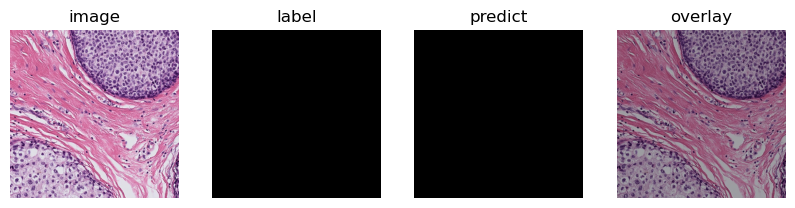

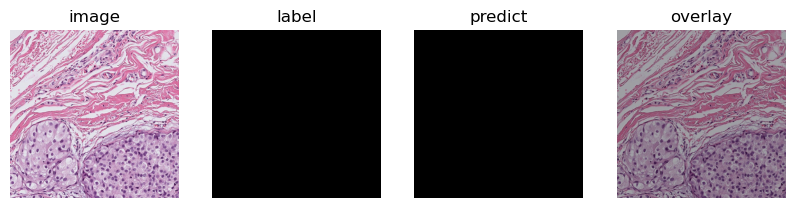

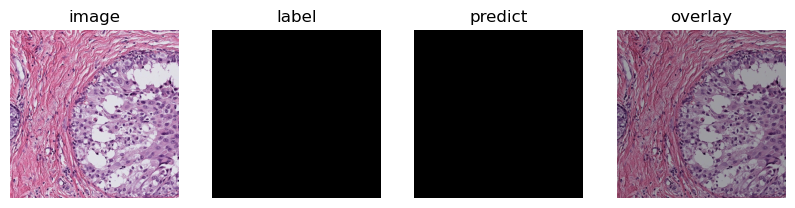

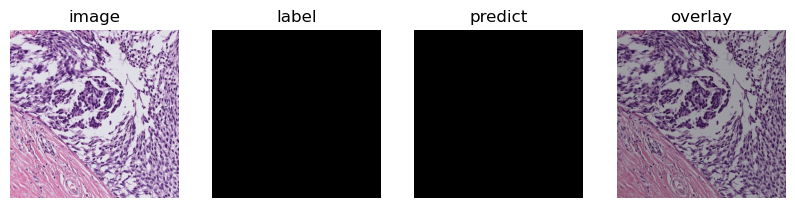

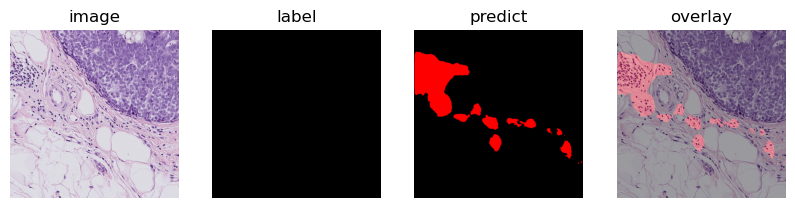

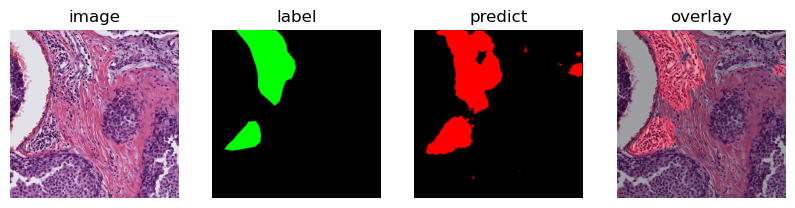

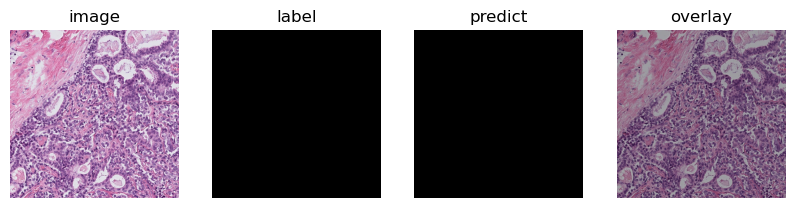

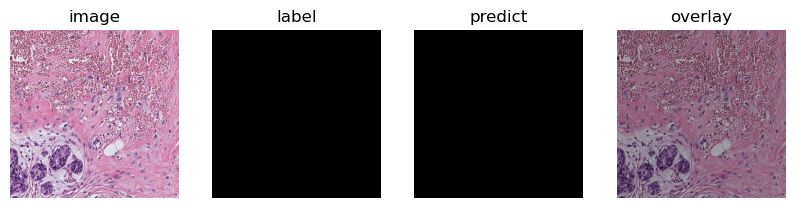

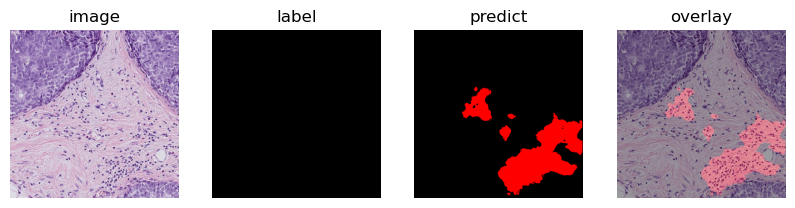

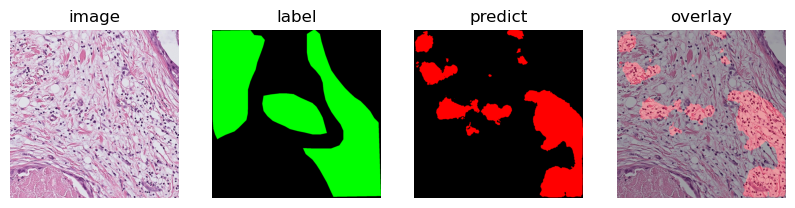

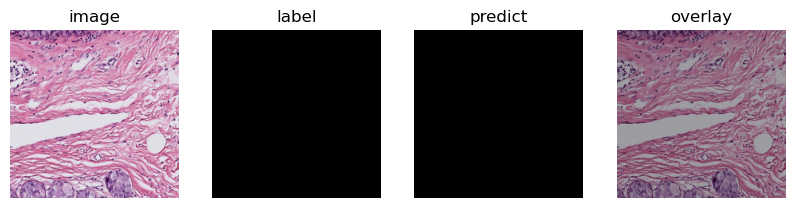

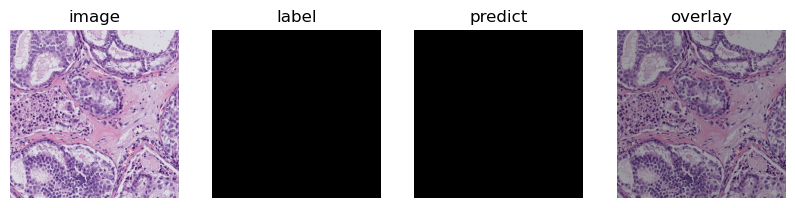

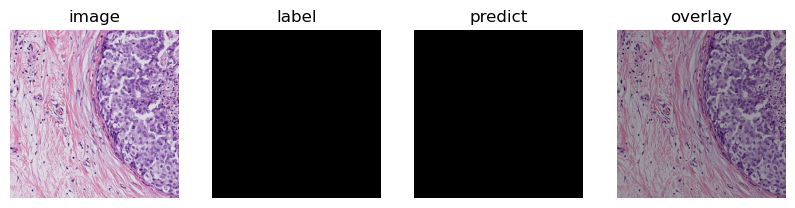

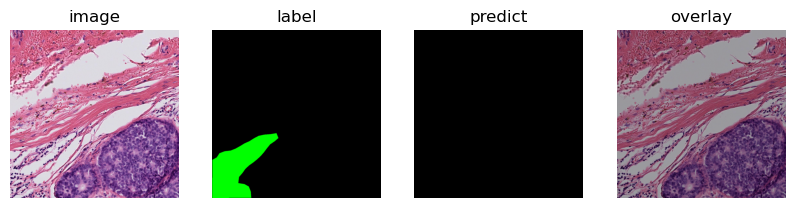

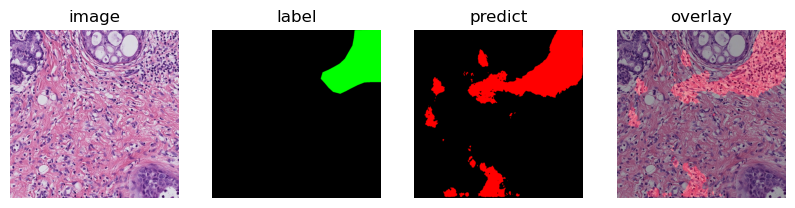

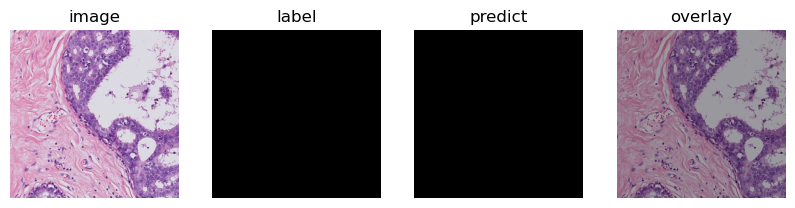

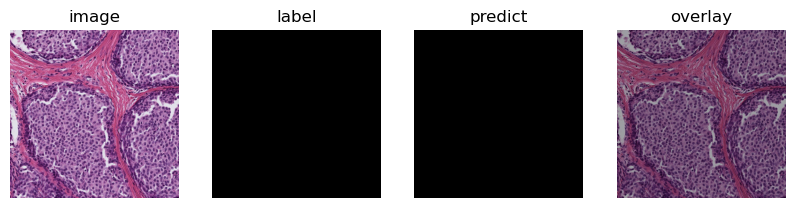

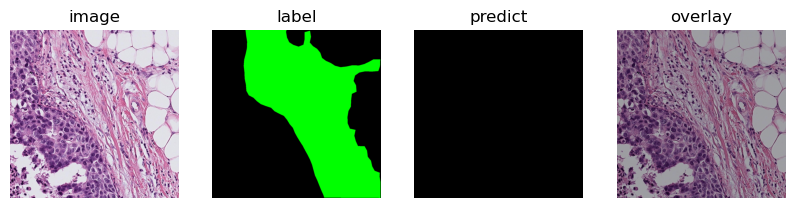

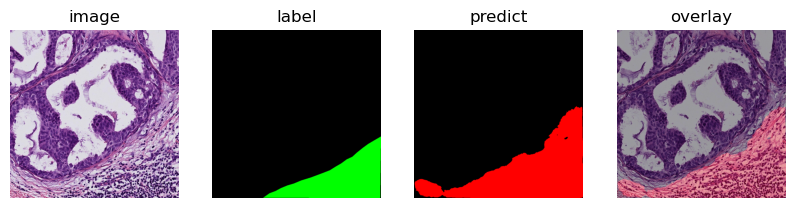

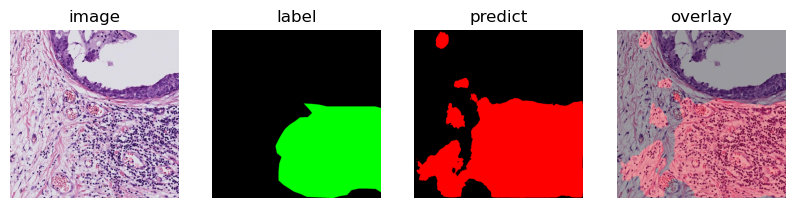

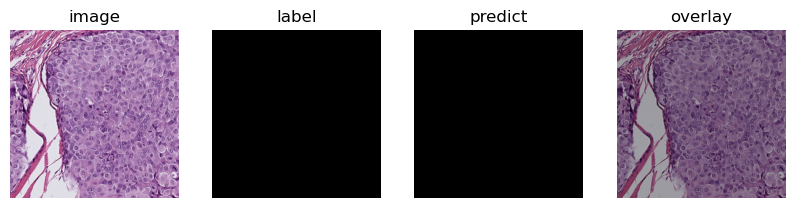

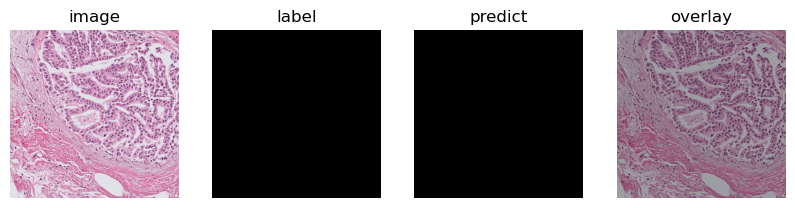

batch size= 4
image size= 224
learning rate= 0.0001


In [5]:
topilimage = torchvision.transforms.ToPILImage()

train_loss_list=[]
val_loss_list=[]
train_acc_list=[]
val_acc_list=[]
MIN_loss=5000
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-4)
metrics = defaultdict(float)
model.eval()
count=0
val_running_loss=0.0
acc_loss=0
with torch.no_grad():
    for x, y in test_dataloader:
        y = y.to(device).float()
        count+=1
        x=x.to(device).float()
        predict = model(x).to(device)
        cost = dice_loss(predict, y).cpu().numpy()
        y = y.to('cpu')
        x=x.to('cpu')
        val_loss_list.append(1-cost)
        if count%5==0:
            pred_softmax = F.softmax(predict, dim=1).cpu()
            mask=torch.zeros((3,img_size,img_size))
            mask[0]=torch.where(pred_softmax.argmax(dim=1)==1,1,0)
            label=torch.zeros((3,img_size,img_size))
            label[1]=torch.where(y.argmax(dim=1)==1,1,0)
            img=topilimage(x[0])
            label=topilimage(label)
            mask=topilimage(mask)
            overlay=np.array(img)*0.7+np.array(mask)*0.3
            overlay=Image.fromarray(overlay.astype('uint8'))
            fig = plt.figure(figsize=(10,30))
            rows = 1
            cols = 4
            ax1 = fig.add_subplot(rows, cols, 1)
            ax1.imshow(img)
            ax1.set_title('image')
            ax1.axis("off")
            
            ax2 = fig.add_subplot(rows, cols, 2)
            ax2.imshow(label)
            ax2.set_title('label')
            ax2.axis("off")
            
            ax3 = fig.add_subplot(rows, cols, 3)
            ax3.imshow(mask)
            ax3.set_title('predict')
            ax3.axis("off")
            
            ax4 = fig.add_subplot(rows, cols, 4)
            ax4.imshow(overlay)
            ax4.set_title('overlay')
            ax4.axis("off")
            plt.show()
           

print('batch size= 4')
print('image size= 224')
print('learning rate= 0.0001')

In [6]:
dice_score=np.array(val_loss_list)
print(f'{class_nm} Class DSC={dice_score.mean()}')


NT_immune Class DSC=0.8929234147071838


In [8]:
from shapely.geometry import Polygon, MultiPolygon
import cv2
def binary_mask_to_polygon(binary_mask):
    # binary_mask는 2차원 numpy array여야 합니다.
    # Contours를 찾습니다.
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    polygons = []
    for contour in contours:
        # 각 contour를 polygon으로 변환
        if len(contour) >= 3:  # 유효한 polygon을 만들기 위해서 최소한 3개의 점이 필요합니다.
            poly = Polygon(shell=[(point[0][0], point[0][1]) for point in contour])
            polygons.append(poly)
    
    if len(polygons) > 1:
        # 여러 개의 polygon이 있을 경우 MultiPolygon으로 변환
        return polygons
    elif len(polygons) == 1:
        return polygons[0]
    else:
        return None
    
poly=binary_mask_to_polygon(np.array(mask)[...,1])
polygon_arrays = []
for polygon in poly.geoms:
    exterior_coords = np.array(polygon.exterior.coords)
    polygon_arrays.append(exterior_coords)

# 변환된 numpy 배열 출력
for i, array in enumerate(polygon_arrays):
    print(f"Polygon {i+1} coordinates:")
    print(array)

AttributeError: 'NoneType' object has no attribute 'geoms'

In [ ]:
for polygon in poly:
    print(polygon)

POLYGON ((240 412, 240 413, 241 413, 240 412))
POLYGON ((192 293, 192 294, 193 294, 194 295, 192 293))
POLYGON ((168 195, 168 197, 169 198, 168 199, 169 199, 170 200, 171 199, 169 197, 169 195, 168 195))
POLYGON ((968 82, 968 83, 969 83, 968 82))
POLYGON ((961 78, 962 79, 963 78, 962 79, 961 78))
POLYGON ((899 54, 899 55, 900 56, 902 56, 903 57, 903 56, 901 56, 899 54))
POLYGON ((945 4, 944 5, 929 5, 928 6, 927 5, 915 5, 914 6, 913 6, 912 7, 911 7, 910 6, 910 5, 900 5, 899 6, 898 5, 895 5, 894 6, 893 5, 889 5, 888 6, 887 6, 886 5, 880 5, 879 6, 878 5, 879 6, 878 7, 870 7, 869 6, 865 6, 864 5, 864 6, 863 7, 862 6, 862 5, 848 5, 847 6, 846 6, 845 7, 841 7, 840 6, 839 6, 838 5, 837 5, 838 6, 837 7, 835 7, 834 6, 833 7, 829 7, 828 8, 827 7, 824 7, 822 9, 822 10, 818 14, 818 15, 817 16, 816 16, 817 16, 818 15, 821 15, 822 16, 823 16, 824 17, 823 18, 821 18, 821 19, 822 19, 823 20, 825 20, 826 21, 832 21, 833 22, 832 23, 832 24, 830 26, 831 26, 832 25, 837 25, 838 26, 840 26, 842 28, 841 29,

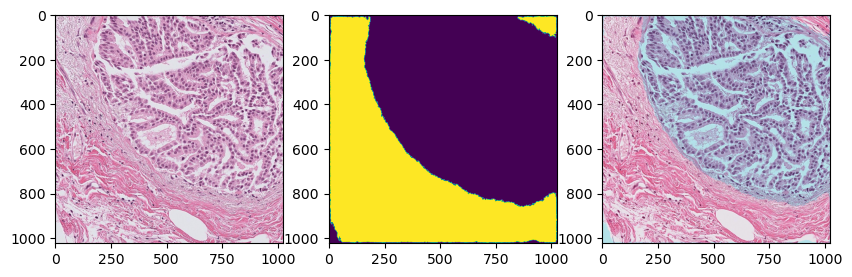

In [ ]:
from skimage.draw import polygon2mask
mask1=np.zeros((1024,1024))
for i in range(len(polygon_arrays)):
    coordinate=np.array(polygon_arrays[i])
    coordinate[:,[0, 1]]=coordinate[:,[1, 0]]
    mask_temp=polygon2mask((1024,1024), coordinate)
    mask1+=mask_temp
ax=plt.figure(figsize=(10,10))
ax.add_subplot(1,3,1)
plt.imshow(img)
ax.add_subplot(1,3,2)
plt.imshow(mask1)
ax.add_subplot(1,3,3)
img1=np.array(img)
img1[...,0]=img1[...,0]*0.8+mask1*255*0.2
plt.imshow(img1)

In [ ]:
len(polygon_arrays)

24

In [ ]:
poly